In [1]:
import os
from helper import init_ipynb
envfound = init_ipynb()

DIR = os.environ["DIR_PATH"] if envfound else None
DEVICE = os.environ["DEVICE"] if envfound else None
API_KEY = os.environ["API_KEY"] if envfound else None
%load_ext autoreload
%autoreload 2

In [2]:
from models import ( HF_LLM, GenerationArg, Model)
from evaluation import MCQBenchmark
import gc
from vllm.distributed.parallel_state import destroy_model_parallel
import torch.distributed
from typing import List, Callable
import pandas as pd
from models.qa_prompts import QA_PROMPTS


import nltk
nltk.download('punkt')

def cot_prompt_template(n_shots: int, q: str, stop_token:str="###") -> str:
    template = QA_PROMPTS["cot_answer_align"]
    shots = '\n'.join(template['shots'][:n_shots])
    return f"""-system:\n{template['system']}\n{shots}{template['q_form'].format(q=q)}""".replace("###", stop_token)

def direct_prompt_template(n_shots: int, q: str, stop_token:str="###") -> str:
    template = QA_PROMPTS["direct_answer_align"]
    shots = '\n'.join(template['shots'][:n_shots])
    return f"""-system:\n{template['system']}\n{shots}{template['q_form'].format(q=q)}""".replace("###", stop_token)

def cot1_prompt_template_support(q: str, shots: List[str], stop_token:str="###") -> str:
    template = QA_PROMPTS["1cot_answer_align"]
    shots = '\n'.join(shots)
    return f"""-system:\n{template['system']}\n{shots}{template['q_form'].format(q=q)}""".replace("###", stop_token)

def cot1_prompt_template(n_shots: int, q: str, stop_token:str="###") -> str:
    template = QA_PROMPTS["1cot_answer_align"]
    shots = '\n'.join(template[shots][:n_shots])
    return f"""-system:\n{template['system']}\n{shots}{template['q_form'].format(q=q)}""".replace("###", stop_token)


def search_ans(pred):
    if(type(pred) != str):
        pred = pred.outputs[0].text
    ans_sentence = [x for x in pred.split(".") if "Therefore" in x]
    

    if(ans_sentence == []):
        return "-1"
    sel = [l for l in ["A", "B", "C", "D", "E"] if l in ans_sentence[0]]
    return sel[0] if sel != [] else "-1"


FLAGS = ["Therefore", "correct", "answer"]
def match_score(sentence):
    return len([flag for flag in FLAGS if flag in sentence]) / len(FLAGS)

def simple_extract(ans_sentence):
    sel = [l for l in ["A", "B", "C", "D", "E"] if l in ans_sentence]
    return sel[0] if sel != [] else "-1"

def csa2(pred):
    if(type(pred) != str):
        pred = pred.outputs[0].text
    sent_text = nltk.sent_tokenize(pred.replace("\n", "??"))
    sentence_score = sorted([[sent, match_score(sent)] for sent in sent_text], key=lambda _: _[1], reverse=True)
    if(len(sentence_score) == 0):
        return "-1"
    sentence, score = sentence_score[0]
    if(score == 0):
        return "-1"
    return simple_extract(sentence)



def write_cache(cache_file:str,
                res,
                targets:List[str]):
    total_cache_file = "docs/benchmarks_results/full/" + cache_file
    with open(total_cache_file) as f:
        singleqa = [f"{res[i].outputs[0].text}\n\n{targets[i]}\n\n{'*'*100}" for i in range(len(targets))]
        f.write("\n\n".join(singleqa))
    print(f"Cached full results on : {cache_file}")


def benchmark(llm: Model,
              benchnames: List[str],
              pt: Callable[[str], str],
              search_ans: Callable[[str], str],
              cache_file:str | None=None,
              support_type:str | None=None,
              n_shots:int | None=3):
    """
        args :
            - model: model to test
            - benchnames : names of the benchmarks to run for the given model
            - pt : prompt template that inputs a question and return the prompt to the model
            - search_ans : a function that finds the answer to the MCQ in the result string
    """
    model_res = []
    for benchname in benchnames:
        print("Evaluation on", benchname)
        benchmark = MCQBenchmark(
            BENCHMARKS_PATHS[benchname],
            pt, ## call with the specific prompt template
            support_type=support_type,
            n_shots=n_shots
        )
        res = benchmark.assess(llm)
        
        if(cache_file is not None):
            ## if a cache_file is inputed => cache out the file
            write_cache(
                cache_file,
                res,
                [q["answer"] for q in benchmark.mcq]
            )
            

        answ = []
        for r in res:
            answ.append(search_ans(r))
        
        model_res.append(
            sum(q["answer"] in ans for ans, q in zip(answ, benchmark.mcq)) / len(answ)
        )
    return model_res


def testbench(
    benchnames:List[str]=["AES7", "AES8"],
    modnames:List[str]=["epfl-llm/meditron-7b", "meta-llama/Llama-2-7b-hf"],
    runargs:List[GenerationArg]=[],
    prompt_template:Callable[[str], str]=lambda x : x,
    search_ans:Callable[[str], str]=lambda x : x,
    use_vllm:bool=True,
    cache_file:str | None=None,
    support_type:str | None=None,
    n_shots:int | None=3,
    ) -> pd.DataFrame:
    
    all_res = []
    for mod in modnames:
        print("<" + "-" * 100 + ">")
        try : 
        ## creating and loading the model
            llm = HF_LLM(
                        mod,
                        device=DEVICE,
                        use_vllm=use_vllm,
                        arg=GenerationArg(use_vllm=use_vllm)
                    )
            llm.load()

            for runarg in runargs:
                ## update the model with current runargs
                llm.set_arg(runarg)

                ## run the benchmarks
                rr = [mod] \
                    + [v for k, v in runarg.attr.items()] \
                    + benchmark(llm, benchnames, prompt_template, search_ans, cache_file, support_type, n_shots) 
                all_res.append(rr)
            destroy_model_parallel()
            del llm
            gc.collect()
            torch.cuda.empty_cache()
            torch.distributed.destroy_process_group()
        except Exception as e:    
            ## unload the model
            print("Unloading the model")
            destroy_model_parallel()
            del llm
            gc.collect()
            torch.cuda.empty_cache()
            torch.distributed.destroy_process_group()
            raise Exception(e)
    cols = ["mod"] + [k for k, v in runargs[0].attr.items()] + benchnames
    return pd.DataFrame(all_res, columns=cols)

BENCHMARKS_PATHS = {
    "MCQ" : "docs/benchmarks/mcq40/processed.json",
    "AES7" : "docs/benchmarks/self_assessment/aes7_processed.json",
    "AES8" :  "docs/benchmarks/self_assessment/aes8_processed.json",
    "AES9" :  "docs/benchmarks/self_assessment/aes9_processed.json",
    "FULL" :  "docs/benchmarks/self_assessment/final_processed.json",
}

We've set API key :  f0555591d0410671711554a53411c6d7


/home/antoinemagron/.conda/envs/nlp2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/antoinemagron/.conda/envs/nlp2/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /home/antoinemagron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Ablation studies


### Ablation on number of shots for COT1

In [3]:
modnames = ["epfl-llm/meditron-7b", "meta-llama/Meta-Llama-3-8B", "meta-llama/Llama-2-7b-hf"]
benchnames = ["AES7", "AES8", "AES9"]
DETERMINISTIC = GenerationArg(
        temperature=0.001,
        use_vllm=True,
        topk=1,
        topp=1,
        max_new_token=512,
        stop_seq="<|STOP|>"
    )

In [ ]:
results = []
for shots in range(4):
    resdf = testbench(benchnames=benchnames,
              runargs=[DETERMINISTIC],
              prompt_template=lambda q : cot1_prompt_template(shots, q, stop_token="<|STOP|>"),
              search_ans=search_ans,
              modnames=modnames,
              use_vllm=True)
    resdf["shots"] = shots
    results.append(resdf)

In [5]:
pd.concat(results).to_csv("docs/benchmarks_results/ablation_study.csv")

## Study the results

In [5]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

BENCHMARKS_PATHS = {
    "MCQ" : "docs/benchmarks/mcq40/processed.json",
    "AES7" : "docs/benchmarks/self_assessment/aes7_processed.json",
    "AES8" :  "docs/benchmarks/self_assessment/aes8_processed.json",
}


human_accuracies = {
    "AES7" : sum([_["human_accuracy"] for _ in MCQBenchmark(BENCHMARKS_PATHS["AES7"], lambda x : x).mcq]) / 100,
    "AES8" : sum([_["human_accuracy"] for _ in MCQBenchmark(BENCHMARKS_PATHS["AES8"], lambda x : x).mcq]) / 100,
}

human_accuracies["AES"] = sum(s for b, s in human_accuracies.items()) / len(human_accuracies)

GPT_RES_AES7 = 0.41
GPT_RES_AES8 = 0.43

In [7]:
df = pd.read_csv("docs/benchmarks_results/ablation_study.csv").drop("Unnamed: 0", axis=1)
df.count()

mod                  12
temperature          12
top_k                12
top_p                12
max_tokens           12
presence_penalty     12
frequency_penalty    12
use_beam_search      12
logprobs             12
best_of              12
stop                 12
use_vllm             12
AES7                 12
AES8                 12
shots                12
dtype: int64

In [19]:
def perf_plot(df, against="temp", benchnames=["AES7", "AES8"]):
    colors = ["#a1dab4", "#41b6c4", "#2c7fb8", "#253494", "#ffffcc"]
    temps = []
    for bench in benchnames:
        temp = df[["mod", bench, against]]
        temp["bench"] = bench
        temp.columns = ["mod", "accuracy", against, "bench"]
        temps.append(temp)
    df = pd.concat(temps)

    df["lines"] = df["mod"].apply(process_mod_name) + " on " + df["bench"]
    
    f, a = plt.subplots(figsize=(10, 5))
    for bench, color in zip(benchnames, colors):
        a.axhline(human_accuracies[bench], linestyle="--", label=f"human score {bench} ", color=color)
    a.axhline((GPT_RES_AES7 + GPT_RES_AES8) / 2 , linestyle="--", label=f"GPT3.5 {bench} ", color="r")
    # a.axhline(0.2 , linestyle="--", label=f"chance", color="b")
    g = sns.lineplot(data=df, x=against, y="accuracy", hue="lines")
    g.set_xlabel(f"Generation {against}")
    g.set_ylabel("Accuracy on benchmark")
    xticks = df.sort_values(against)[against].drop_duplicates().values
    g.set_xticks(xticks)
    g.set_xticklabels(xticks)

def process_mod_name(modname):
    return "-".join(modname.split("/")[1].split("-")[:2])

/tmp/ipykernel_3931326/3573217739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["bench"] = bench
/tmp/ipykernel_3931326/3573217739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["bench"] = bench


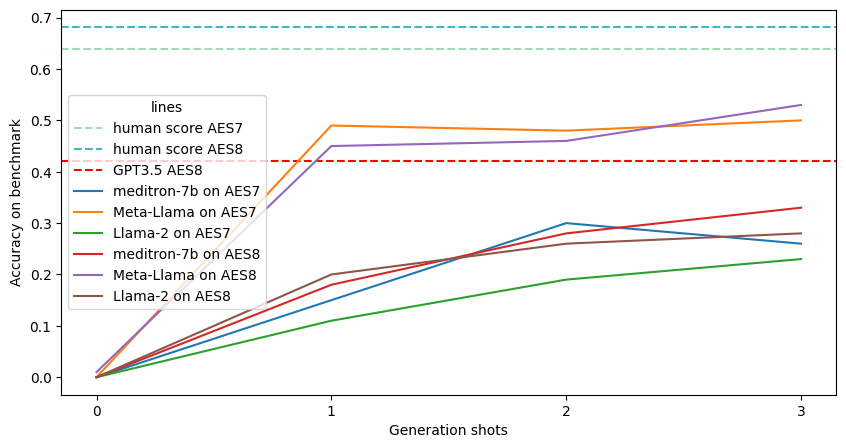

In [9]:
perf_plot(df, against="shots")

In [10]:
print(df.groupby(["mod", "shots"]).agg({"AES7": "mean", "AES8": "mean"}).apply(lambda _ : round(_, 2)).to_latex())

\begin{tabular}{llrr}
\toprule
 &  & AES7 & AES8 \\
mod & shots &  &  \\
\midrule
\multirow[t]{4}{*}{epfl-llm/meditron-7b} & 0 & 0.000000 & 0.000000 \\
 & 1 & 0.150000 & 0.180000 \\
 & 2 & 0.300000 & 0.280000 \\
 & 3 & 0.260000 & 0.330000 \\
\cline{1-4}
\multirow[t]{4}{*}{meta-llama/Llama-2-7b-hf} & 0 & 0.000000 & 0.000000 \\
 & 1 & 0.110000 & 0.200000 \\
 & 2 & 0.190000 & 0.260000 \\
 & 3 & 0.230000 & 0.280000 \\
\cline{1-4}
\multirow[t]{4}{*}{meta-llama/Meta-Llama-3-8B} & 0 & 0.000000 & 0.010000 \\
 & 1 & 0.490000 & 0.450000 \\
 & 2 & 0.480000 & 0.460000 \\
 & 3 & 0.500000 & 0.530000 \\
\cline{1-4}
\bottomrule
\end{tabular}



### Type of shots selection (demonstration retrieval)

In [ ]:
results = []
for support_type in ["deterministic", "kNN"]:
    print("<" + "-" * 30 + " "* 3 + support_type + " " * 3 + "-"* 30 + ">") 
    n_shots = 3
    resdf = testbench(benchnames=benchnames,
            runargs=[DETERMINISTIC],
            prompt_template=lambda q, shots : cot1_prompt_template_support(q, shots, stop_token="<|STOP|>"),
            search_ans=search_ans,
            modnames=modnames,
            use_vllm=True,
            n_shots=n_shots,
            support_type=support_type
            )
    resdf["shots"] = n_shots
    resdf["support_type"] = support_type
    results.append(resdf)

In [ ]:
results = []
support_type = "random"
n_shots = 3
for _ in range(5):
    resdf = testbench(benchnames=benchnames,
            runargs=[DETERMINISTIC],
            prompt_template=lambda q, shots : cot1_prompt_template_support(q, shots, stop_token="<|STOP|>"),
            search_ans=search_ans,
            modnames=modnames,
            use_vllm=True,
            n_shots=n_shots,
            support_type=support_type
            )
    resdf["shots"] = n_shots
    resdf["support_type"] = support_type
    results.append(resdf)

In [21]:
df = pd.concat(results)
df.to_csv("docs/support_type_analysis.csv")

In [62]:
df = pd.read_csv("docs/support_type_analysis.csv")

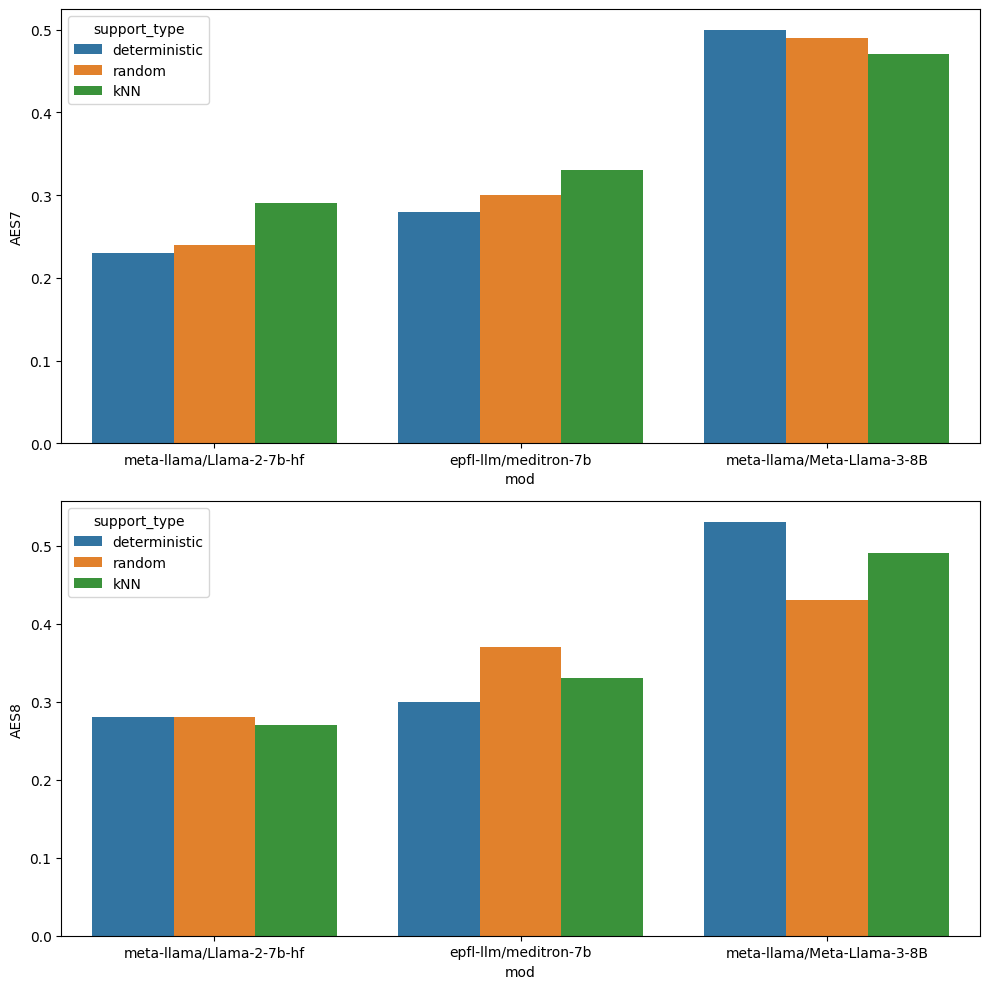

In [30]:
df = df.sort_values("AES7")
f, a = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(
    data=df,
    y="AES7",
    hue="support_type",
    x="mod",
    ax=a[0]
)
sns.barplot(
    data=df,
    y="AES8",
    hue="support_type",
    x="mod",
    ax=a[1]
)
plt.tight_layout()

<ins>Conclusion:</ins> The smaller models benefits from kNN and even randomness while LLaMa-3 benefits more from well crafted prompts.



Adding ChatGPT to this ablation study

In [ ]:
from models import OpenAIGPT

MARKER = "X00A"

def cot1_prompt_template_gpt(q: str, shots: List[str]) -> List[str]:
    template = QA_PROMPTS["1cot_answer_align"]
    messages = [
        {
            "role": "system",
            "content": template["system"]
        }
    ]
    for shot in shots:
        contents = shot.replace("-user:", MARKER).replace("-assistant:", MARKER).split(MARKER)
        contents = [x.strip() for x in contents if x != ""]
        messages.append({
            "role": "user",
            "content": contents[0]
        })
        messages.append({
            "role": "assistant",
            "content": contents[1]
        })
    messages.append({
        "role": "user",
        "content": ("Question : " + q)
    })
    return messages


gpt = OpenAIGPT(model="gpt-3.5-turbo")
gpt.set_key(API_KEY)


results = []
for support_type in ["deterministic", "random", "kNN"]:
    print("<" + "-" * 100 + ">")
    for _ in range(5 if support_type == "random" else 1):
        results.append(
            MCQBenchmark(
                BENCHMARKS_PATHS["AES7"],
                cot1_prompt_template_gpt,
                support_type=support_type,
                n_shots=3
            ).assess(gpt)
        )
        results.append(
            MCQBenchmark(
                BENCHMARKS_PATHS["AES8"],
                cot1_prompt_template_gpt,
                support_type=support_type,
                n_shots=3
            ).assess(gpt)
        )

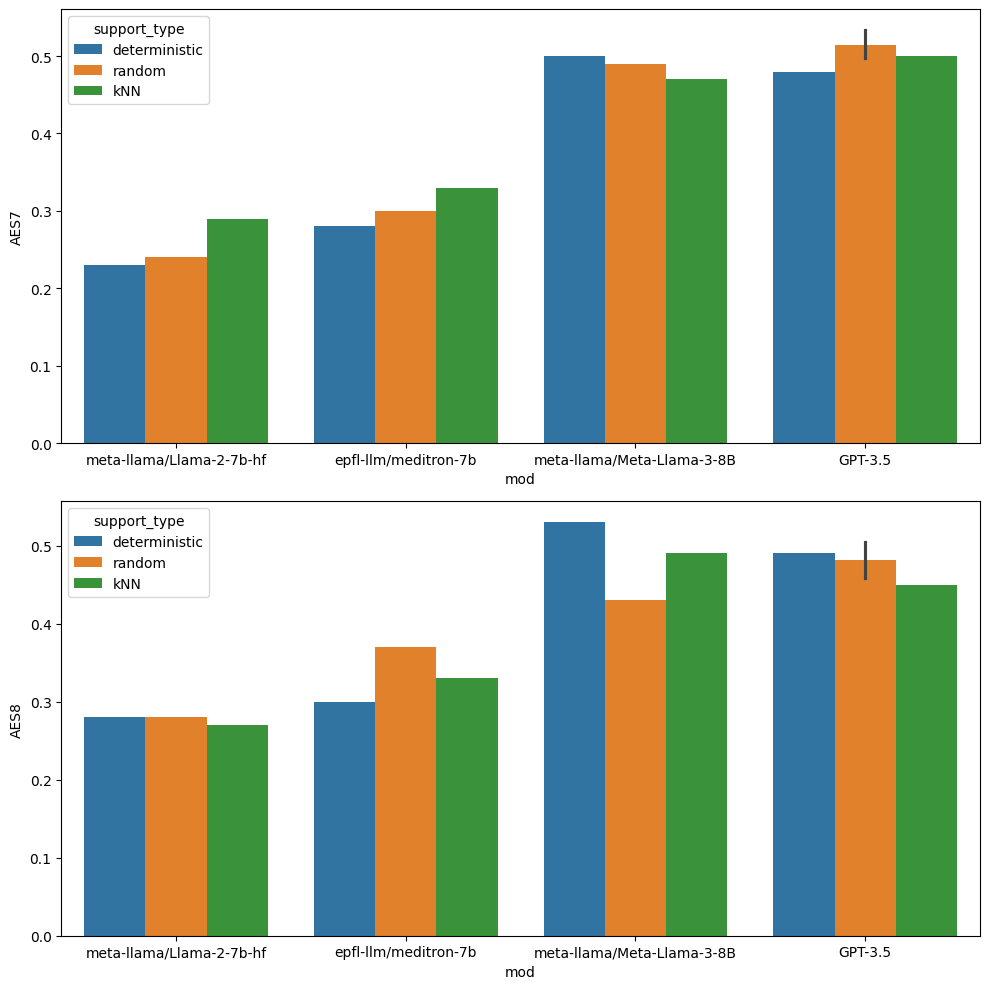

In [67]:
gpt_res = []
for exp in results:
    acc = 0
    for sample in exp:
        acc += int(sample["answer"] == csa2(sample["prediction"]))
    gpt_res.append(
        acc / 100
    )
aes7_gpt_res = gpt_res[::2]
aes8_gpt_res = gpt_res[1::2]
support_types = []
models = []
benchs = []
for support_type in ["deterministic", "random", "kNN"]:
    for _ in range(5 if support_type == "random" else 1):
            support_types.append(
                support_type
            )
            models.append("GPT-3.5")


df_full = pd.concat([df, pd.DataFrame({
    "mod" : models,
    "support_type" : support_types,
    "AES7" : aes7_gpt_res,
    "AES8" : aes8_gpt_res 
    })
])



df = df.sort_values("AES7")
f, a = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(
    data=df_full,
    y="AES7",
    hue="support_type",
    x="mod",
    ax=a[0]
)
sns.barplot(
    data=df_full,
    y="AES8",
    hue="support_type",
    x="mod",
    ax=a[1]
)
plt.tight_layout()

# Testing our model 

In [3]:
DETERMINISTIC_VLLM = GenerationArg(
        temperature=0.001,
        use_vllm=True,
        topk=1,
        topp=1,
        max_new_token=512,
        stop_seq="<|STOP|>"
    )
test_epitron_baseline_M7B_PMCo = testbench(
    modnames=["checkpoints/epitron_baseline_PMCo_M7B_e3"],
    benchnames=["AES7", "AES8", "AES9"],
    runargs=[DETERMINISTIC_VLLM],
    prompt_template=lambda q, shots : cot1_prompt_template_support(q, shots, stop_token="<|STOP|>"),
    search_ans=csa2,
    use_vllm=True,
    n_shots=3,
    support_type="kNN"
)

<---------------------------------------------------------------------------------------------------->
INFO 06-03 15:28:20 llm_engine.py:100] Initializing an LLM engine (v0.4.2) with config: model='checkpoints/epitron_baseline_PMCo_M7B_e3', speculative_config=None, tokenizer='checkpoints/epitron_baseline_PMCo_M7B_e3', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=checkpoints/epitron_baseline_PMCo_M7B_e3)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 06-03 15:28:20 utils.py:660] Found nccl from library /home/antoinemagron/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 06-03 15:28:20 selector.py:27] Using FlashAttention-2 backend.
INFO 06-03 15:30:55 model_runner.py:175] Loading model weights took 12.5527 GB
INFO 06-03 15:30:56 gpu_executor.py:114] # GPU blocks: 3775, # CPU blocks: 512
INFO 06-03 15:30:57 model_runner.py:937] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 06-03 15:30:57 model_runner.py:941] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 06-03 15:31:03 model_runner.py:1017] Graph capturing finished in 6 secs.
Evaluation on AES7


/home/antoinemagron/.conda/envs/nlp2/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[['-user:\nQuestion : Deep brain stimulation for drug-resistant epilepsy targets which of the following structures?\n        A. anterior nucleus of the thalamus\n        B. centromedian nucleus of the thalamus\n        C. cingulate gyrus\n        D. hippocampus\n        E. internal segment of the globus pallidus\n-assistant:\nAnswer :  The anterior nucleus of the thalamus is part of the Papez circuit and is therefore believed to be a relay station for information passing from the amygdala and hippocampus to the cerebral cortex. Data have shown that inhibition of the anterior nucleus may result in prevention or cessation of seizures. \nTherefore, the correct answer is A.###', '-user:\nQuestion : According to the International League Against Epilepsy’s 2010 revision of its seizure classification system, which of the following factors is most helpful in initially focusing the scope of diagnostic possibilities for specific electroclinical syndromes?\n        A. age at onset\n        B. fam

Processed prompts: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Evaluation on AES8
[['-user:\nQuestion : According to the International League Against Epilepsy’s 2010 revision of its seizure classification system, which of the following factors is most helpful in initially focusing the scope of diagnostic possibilities for specific electroclinical syndromes?\n        A. age at onset\n        B. family seizure history\n        C. frequency of spells\n        D. history of toxic exposure\n        E. severity of the disorder\n-assistant:\nAnswer :  While all the other factors mentioned should be part of an initial seizure history, they are not as important in establishing the ultimate diagnosis. \nTherefore, the correct answer is A.###', '-user:\nQuestion : Which of the following conditions would likely preclude the consideration of epilepsy surgery in a patient?\n        A. dominant hemisphere focus\n        B. low-grade tumor\n        C. mental retardation\n        D. primary generalized epilepsy\n        E. prior vagus nerve stimulator use\n-assist

Processed prompts: 100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Evaluation on AES9
[['-user:\nQuestion : A 10-year-old child with epilepsy since age 2 that is refractory to medical treatment has been followed serially with brain MRI scans, which show progressive atrophy of the left hemisphere. What is the most likely diagnosis?\n        A. focal cortical dysplasia\n        B. neurofibromatosis\n        C. Rasmussen encephalitis\n        D. Sturge-Weber syndrome\n        E. tuberous sclerosis\n-assistant:\nAnswer :  MRI in Rasmussen encephalitis shows progressive atrophy of one of the cerebral hemispheres, usually beginning in the opercular region. \nTherefore, the correct answer is C.###', '-user:\nQuestion : A 21-year-old man is seen in clinic for management of seizures. He has had several episodes of generalized tonic-clonic seizure activity with resultant oral trauma and incontinence. Some of his events may have started with focal shaking in the right arm, although this history is unclear and is unable to be corroborated. EEG reveals no epilepti

Processed prompts: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


In [4]:
test_epitron_baseline_M7B_PMCo

,mod,temperature,top_k,top_p,max_tokens,presence_penalty,frequency_penalty,use_beam_search,logprobs,best_of,stop,use_vllm,AES7,AES8,AES9
0,checkpoints/epitron_baseline_PMCo_M7B_e3,0.001,1,1,512,0.0,1.0,False,5,1,<|STOP|>,True,0.08,0.12,0.06


In [3]:
DETERMINISTIC_HF = GenerationArg(
        temperature=0.001,
        use_vllm=False,
        topk=1,
        topp=1,
        max_new_token=512,
        stop_seq="<|STOP|>"
    )
llm = HF_LLM(
    "checkpoints/epitron_baseline_PMCo_M7B_e3",
    arg=DETERMINISTIC_HF,
    use_vllm=False,
    device="cuda"
)
llm.load()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
mcq = MCQBenchmark(BENCHMARKS_PATHS["AES7"],
                   prompt_template=lambda q, n_shots : cot1_prompt_template_support(q, n_shots, stop_token="<|STOP|>"),
                   n_shots=3,support_type="deterministic")

mcq.mcq = mcq.mcq[10:13]

In [6]:
res = mcq.assess(
    llm
)

[['-user: \n            Question :  A 63-year-old woman is hospitalized with herpes simplex virus encephalitis. Which of the following EEG patterns is most likely to be seen in this patient?\n                A. burst suppression\n                B. generalized periodic discharges\n                C. periodic lateralizing discharges\n                D. small sharp spikes\n                E. stimulus-induced, rhythmic, periodic, or ictal discharges\n            -assistant:\n            Answer :  Periodic lateralizing discharges are EEG abnormalities commonly seen in certain scenarios, including herpes encephalitis. Other conditions in which periodic lateralizing discharges are seen include focal brain lesions, nonketotic hyperglycemia, alcohol withdrawal, and theophylline exposure. Generalized periodic discharges are more commonly seen in anoxic brain injury, Creutzfeldt-Jakob disease, and other diffuse processes. Stimulus-induced, rhythmic, periodic, or ictal discharges (SIRPIDs) are mo

  0%|          | 0/3 [00:00<?, ?it/s]

/home/antoinemagron/.conda/envs/nlp2/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/antoinemagron/.conda/envs/nlp2/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:537: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


KeyboardInterrupt: 

In [4]:
[r["prediction"][0].split("Answer :")[-1] for r in res]

NameError: name 'res' is not defined

In [5]:
[r.outputs[0].text for r in res]

['           <EOD>....................-.-.-.-.-.-.-.---------−−−−−−−− − − − − − − − − - - - - - - - - - -- -- -- -- -- -- -- -- ~ ~ ~ ~ ~ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~～～=-=-=-========:::::::::::::::::::::::::::-:-:-:-:-:-:-:-,-,-,-,-,,,,,,,,,,,,,,,,,,,,, , , , , , , , ,，，.,.,.,.,.,.,.,.,-,-,-,-,-,-,_,_,_,_,_______ _ _ _ _ _ _ _ _ _ _._._._._._._._.__._._._._._._._. . . . . . . . . .. .. .. .. .. .. .. .. ... ... ... ... ... ... ... .... ........................................…………………… … … … … … … … … … ° ° ° °°°°°°°°° degree degree degree degree degree degree deg deg deg deg deg deg deg deg eg eg eg eg eg egegegegegegegegegegggggggg g g g g g g g g g gg gg gg gg ggggggggggggggggggggggGGGGGGGGGGGGGGGGG G G G G G G G G G G G G A A A A A A AAAAAAAAAAAAAAAAAAAAAAAAA AA AA AA AA AA AA AA AA AA AG AG AG AG AGAGAGAGAGAGAGAGAGAgAgAgAgAgAgAgAg Ag Ag Ag Ag Ag Ag Ag Ag Ag ag ag ag ag ag ag ag agagagagagagagagagagagaggaggaggaggaggaggaggaggagragragragragragr agr agr agr agr agr 

In [7]:
del llm

### Final bench

In [5]:
DETERMINISTIC_VLLM = GenerationArg(
        temperature=0.001,
        use_vllm=True,
        topk=1,
        topp=1,
        max_new_token=512,
        stop_seq="<|STOP|>"
    )
test_baseline_LL3 = testbench(
    modnames=[
        "meta-llama/Meta-Llama-3-8B",
        # "epfl-llm/meditron-7b",
        # "meta-llama/Llama-2-7b-hf"
    ],
    benchnames=["FULL"],
    runargs=[DETERMINISTIC_VLLM],
    prompt_template=lambda q, shots : cot1_prompt_template_support(q, shots, stop_token="<|STOP|>"),
    search_ans=csa2,
    use_vllm=True,
    n_shots=3,
    support_type="kNN"
)

<---------------------------------------------------------------------------------------------------->


/home/antoinemagron/.conda/envs/nlp2/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


INFO 06-03 16:25:51 llm_engine.py:100] Initializing an LLM engine (v0.4.2) with config: model='meta-llama/Meta-Llama-3-8B', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=meta-llama/Meta-Llama-3-8B)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 06-03 16:25:51 utils.py:660] Found nccl from library /home/antoinemagron/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 06-03 16:25:51 selector.py:27] Using FlashAttention-2 backend.
INFO 06-03 16:25:51 weight_utils.py:199] Using model weights format ['*.safetensors']
INFO 06-03 16:25:53 model_runner.py:175] Loading model weights took 14.9595 GB
INFO 06-03 16:25:55 gpu_executor.py:114] # GPU blocks: 13247, # CPU blocks: 2048
INFO 06-03 16:25:56 model_runner.py:937] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 06-03 16:25:56 model_runner.py:941] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 06-03 16:26:01 model_runner.py:1017] Graph ca

Processed prompts: 100%|██████████| 224/224 [00:39<00:00,  5.64it/s]


In [6]:
test_baseline_LL3

,mod,temperature,top_k,top_p,max_tokens,presence_penalty,frequency_penalty,use_beam_search,logprobs,best_of,stop,use_vllm,FULL
0,meta-llama/Meta-Llama-3-8B,0.001,1,1,512,0.0,1.0,False,5,1,<|STOP|>,True,0.491071


In [3]:
DETERMINISTIC_VLLM = GenerationArg(
        temperature=0.001,
        use_vllm=True,
        topk=1,
        topp=1,
        max_new_token=512,
        stop_seq="<|STOP|>"
    )
baseline_M7B= testbench(
    modnames=[
        # "meta-llama/Meta-Llama-3-8B",
        "epfl-llm/meditron-7b",
        # "meta-llama/Llama-2-7b-hf"
    ],
    benchnames=["FULL"],
    runargs=[DETERMINISTIC_VLLM],
    prompt_template=lambda q, shots : cot1_prompt_template_support(q, shots, stop_token="<|STOP|>"),
    search_ans=csa2,
    use_vllm=True,
    n_shots=3,
    support_type="kNN"
)

<---------------------------------------------------------------------------------------------------->
INFO 06-03 16:28:02 llm_engine.py:100] Initializing an LLM engine (v0.4.2) with config: model='epfl-llm/meditron-7b', speculative_config=None, tokenizer='epfl-llm/meditron-7b', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=epfl-llm/meditron-7b)


/home/antoinemagron/.conda/envs/nlp2/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 06-03 16:28:02 utils.py:660] Found nccl from library /home/antoinemagron/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 06-03 16:28:03 selector.py:27] Using FlashAttention-2 backend.
INFO 06-03 16:28:03 weight_utils.py:199] Using model weights format ['*.safetensors']
INFO 06-03 16:28:06 model_runner.py:175] Loading model weights took 12.5527 GB
INFO 06-03 16:28:06 gpu_executor.py:114] # GPU blocks: 3775, # CPU blocks: 512
INFO 06-03 16:28:07 model_runner.py:937] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 06-03 16:28:07 model_runner.py:941] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 06-03 16:28:13 model_runner.py:1017] Graph capt

Processed prompts: 100%|██████████| 224/224 [01:19<00:00,  2.81it/s]


In [4]:
baseline_M7B

,mod,temperature,top_k,top_p,max_tokens,presence_penalty,frequency_penalty,use_beam_search,logprobs,best_of,stop,use_vllm,FULL
0,epfl-llm/meditron-7b,0.001,1,1,512,0.0,1.0,False,5,1,<|STOP|>,True,0.3125


In [3]:
DETERMINISTIC_VLLM = GenerationArg(
        temperature=0.001,
        use_vllm=True,
        topk=1,
        topp=1,
        max_new_token=512,
        stop_seq="<|STOP|>"
    )
baseline_LL2= testbench(
    modnames=[
        # "meta-llama/Meta-Llama-3-8B",
        # "epfl-llm/meditron-7b",
        "meta-llama/Llama-2-7b-hf"
    ],
    benchnames=["FULL"],
    runargs=[DETERMINISTIC_VLLM],
    prompt_template=lambda q, shots : cot1_prompt_template_support(q, shots, stop_token="<|STOP|>"),
    search_ans=csa2,
    use_vllm=True,
    n_shots=3,
    support_type="kNN"
)
baseline_LL2

<---------------------------------------------------------------------------------------------------->
INFO 06-03 16:31:46 llm_engine.py:100] Initializing an LLM engine (v0.4.2) with config: model='meta-llama/Llama-2-7b-hf', speculative_config=None, tokenizer='meta-llama/Llama-2-7b-hf', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=meta-llama/Llama-2-7b-hf)


/home/antoinemagron/.conda/envs/nlp2/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


INFO 06-03 16:31:46 utils.py:660] Found nccl from library /home/antoinemagron/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 06-03 16:31:46 selector.py:27] Using FlashAttention-2 backend.
INFO 06-03 16:31:46 weight_utils.py:199] Using model weights format ['*.safetensors']
INFO 06-03 16:31:52 model_runner.py:175] Loading model weights took 12.5523 GB
INFO 06-03 16:31:53 gpu_executor.py:114] # GPU blocks: 3768, # CPU blocks: 512
INFO 06-03 16:31:54 model_runner.py:937] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 06-03 16:31:54 model_runner.py:941] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 06-03 16:32:00 model_runner.py:1017] Graph capt

Processed prompts: 100%|██████████| 224/224 [01:07<00:00,  3.34it/s]


,mod,temperature,top_k,top_p,max_tokens,presence_penalty,frequency_penalty,use_beam_search,logprobs,best_of,stop,use_vllm,FULL
0,meta-llama/Llama-2-7b-hf,0.001,1,1,512,0.0,1.0,False,5,1,<|STOP|>,True,0.276786
